<center> 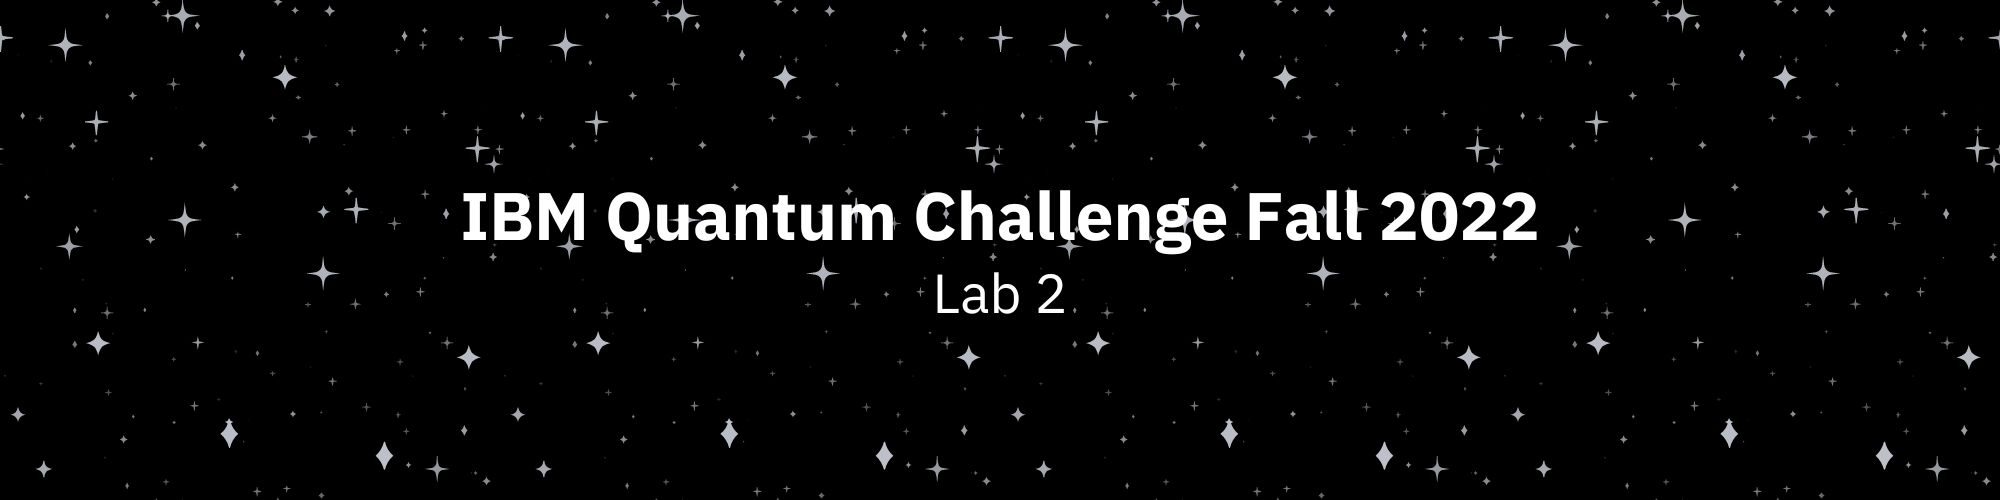 </center>

# Quantum Kernel Learning with Qiskit Runtime

# Table of Contents
- **[Story](#Story)**
- **[Part I: Data Encoding and Probability Distribution](#Part-I:-Data-Encoding-and-Probability-Distribution)**
    - **[Exercise 1: Parameterized Circuit](#exercise1)**
- **[Part II: Implementing Error Mitigation in a Sampler](#Part-II:-Implementing-Error-Mitigation-in-a-Sampler)**
    - **[Exercise 2: Matrix-free Measurement Mitigation (M3)](#exercise2)**
- **[Part III: Estimating State Fidelities with a Sampler](#Part-III:-Estimating-State-Fidelities-with-a-Sampler)**
    - **[Exercise 3: State Fidelities with a Sampler](#exercise3)**
- **[Part IV: Quantum Kernels and Quantum Support Vector Machines](#Part-IV:-Quantum-Kernels-and-Quantum-Support-Vector-Machines)**
    - **[Exercise 4: Quantum Kernel with Sampler](#exercise4)**
    - **[Exercise 5: Recognize Unknown Bitstring](#exercise5)**

# Story - Chapter 2

Listen to the unscrambled Captain's Log here: **[Captain's Log](https://youtu.be/tBEcjZn56_E)**

<details><summary><b>**Click to Expand: Log Transcript**</b></summary>
<p>
    “Captain’s Log, Supplemental 

Our gravity assist maneuver was a failure. After extensive calculations, we chose what we thought would be the perfect planet for our slingshot, but we fell short and were forced to make an emergency landing on the surface. It turns out our quantum computers and quantum scanners were glitchy, more than their usual noisiness, and our error mitigation techniques weren't sufficient.
 

This planet is...beautiful. It has a breathable atmosphere, and gigantic plants with flowers the size of teapots. But we are not able leave: it seems there is no fuel on this planet, and the black hole looms in the sky. The crew is devastated, of course. In a little while, I will address them, give them comfort and hope. 


There’s just one last thing I want to try.
 
You see, I noticed something peculiar in our timekeepers. There’s one that is always synced with Earth so we know the time back home no matter where we are. And according to that timekeeper, we are...hundreds of years ahead. In the future. 


Further, it appears as though each one of our minutes corresponds to a decade passing on Earth. 
 

And so, I record this, both as a log, and as a message for a beacon I will launch into the stars, in the hopes that I—the I from the past—will find it.
 

If you—me—are listening to this, I implore you. Please do not rely on your calculations. Your systems are broken. I repeat: your systems are broken. Fix them first.
 

As for me? I intend to explore this world, and learn more about black holes and time. It seems we were right about relativity in some ways, but who knew that time loops could exist like this? 


I think, in time, we’ll come to love this place. After all, it’ll be hundreds, perhaps thousands, of years before this planet falls completely into the black hole. 


And perhaps, in time, we’ll learn to harvest the resources on this magnificent planet, and find our way back home.”
    
</p>
</details>

You blink, stunned. You listen to the message again. And again. Though the voice is distorted and unfamiliar, the message is still unmistakably from you, somehow carried across time. Some sort of looping temporal current, perhaps? You've never heard of such a phenomenon, even in theory.


Instinctively, you know this isn’t a hoax. But you ask your engineers to run extensive tests to verify whether your systems really are broken as the message claims, even though you know they must be. After all, the calculations to maintain a safe distance from the black hole had been incorrect, hadn’t they?


You and your crew repair your quantum computers and scanners as best as you can with limited resources. 


Now you must test whether your repairs are successful. Unfortunately, the precision equipment you would normally use is back home on Earth, and so, you devise a way to test it empirically: by classifying data samples you have on board. It is a primitive solution, but sufficient enough for your purposes. 


Complete this lab to test whether your repairs are effective: build a classification routine with a sufficient level of accuracy.

# Preliminary Steps

This lab will focus on applying the error mitigation technique, matrix-free measurement mitigation (M3) to various machine learning application problems, including the quantum support vector machine.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# import Qiskit
from qiskit import *
from qiskit import Aer, execute

Import IBM quantum API token

In [2]:
# Imports json to digest quantum API token
import json

# Import API token from JSON
with open("../ibm-quantum-token.json", 'r') as f:
    my_token_json = json.load(f)
    my_token = my_token_json["token"]

Load environment for offline grading

In [3]:
%%capture
%env QXToken=$my_token
%env QC_GRADING_ENDPOINT=https://qac-grading.quantum-computing.ibm.com
%env QXAuthURL=https://auth.quantum-computing.ibm.com/api

### Auxiliary Functions

First, we set up a bunch of auxiliary functions for data processing and plotting of results here.

In [4]:
def process_samples(circuit, samples):
    """maps dictionary of (quasi-) probabilities to dense vector for illustration.
       (scales exponentially! don't apply to too many qubits!."""
    probs = np.zeros(2**circuit.num_qubits)
    for b, p in samples.quasi_dists[0].items():
        probs[b] = p
    return probs

def plot_probabilities(circuit, probs, label):
    """plots probability vector."""
    x = np.array(range(2**circuit.num_qubits))
    fig, ax = plt.subplots()
    ax.bar(x, probs, align='center', alpha=1, label=label)
    ax.set_title('Probabilities')
    ax.yaxis.grid(True)
    ax.xaxis.set_major_formatter(lambda x, pos: f'{int(x):0{circuit.num_qubits}b}')
    plt.xticks(x[::4], rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_cumulative_probabilities(circuit, probs_list, labels):
    """plots multiple cumulative probabilities."""
    x = np.array(range(2**circuit.num_qubits))
    fig, ax = plt.subplots()
    for i, probs in enumerate(probs_list):
        ax.plot(x, np.cumsum(probs), label=labels[i], linewidth=2)
    ax.set_title('Cumulative Probabilities')
    ax.yaxis.grid(True)
    ax.xaxis.set_major_formatter(lambda x, pos: f'{int(x):0{circuit.num_qubits}b}')
    plt.xticks(x[::4], rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def plot_fidelities(fidelities_list, labels):
    """plots list of fidelities."""
    fig, ax = plt.subplots()
    for fidelity, label in zip(fidelities_list, labels):
        ax.plot(np.linspace(0, 1, len(fidelity)), fidelity, alpha=1, label=label, linewidth=2)
    ax.set_title('Fidelities')
    ax.yaxis.grid(True)
    plt.legend()
    plt.xlabel('c')
    plt.ylabel('fidelity')
    plt.tight_layout()
    plt.show()

def plot_matrix(A, title):
    """plots a given matrix."""
    # plot matrix
    plt.title(title)
    ax = plt.imshow(A, cmap='viridis')
    plt.colorbar(ax)
    plt.tight_layout()
    plt.show()

# Part I: Data Encoding and Probability Distribution 

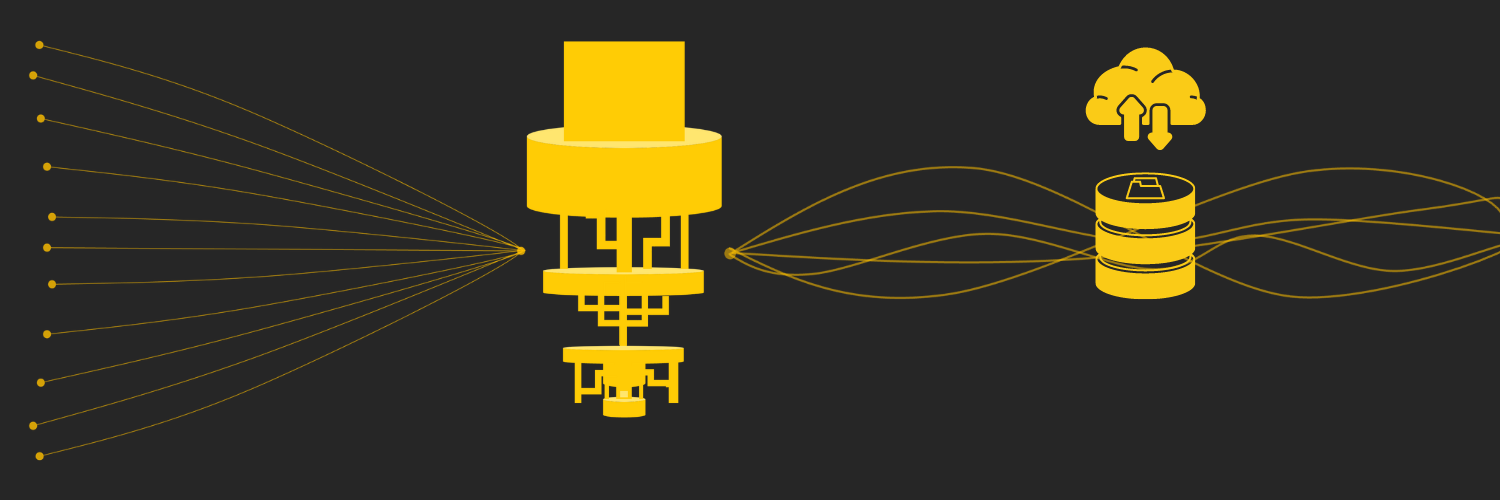


## Quantum Mechanics + Machine Learning?
Machine learning has established itself as a successful interdisciplinary field which seeks to find patterns in data. Quantum computing manipulates the information in ways that can be described by quantum mechanics. Throwing of machine learning into quantum computing creates research interest areas that use the principles of quantum mechanics to enhance machine learning or vice versa. Most of the classical machine learning technologies have made great strides over the past decade with the availability of powerful hardware. The presence of quantum hardware can enable further development in this area **[[1]](https://learn.qiskit.org/course/machine-learning/introduction)**. The purpose of quantum machine learning is to lessen either in terms of sample complexity or amount of operations required to train a model, categorize a test vector, or create a novel example of a concept **[[2]](https://iopscience.iop.org/article/10.1088/1367-2630/abac39/meta)[[3]](https://www.nature.com/articles/nature23474)**.

## Handwritten bit strings
The data samples on your starship are hand-written bit strings. You  need to repair your quantum computers and scanners as best as you can with this limited data sample.

Machine learning technology allows a computer to recognize information in an image. The ultimate goal of handwritten recognition is to mimic human's ability so that they can read, edit, and interact with text in a short time. This has drawn attention of numerous researchers over a half century. You will use the prepared **[dataset](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits)** to improve the accuracy of the Quantum classifier. First, load the dataset.

In [5]:
# import Scikit-learn, a machine learning library for Python
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

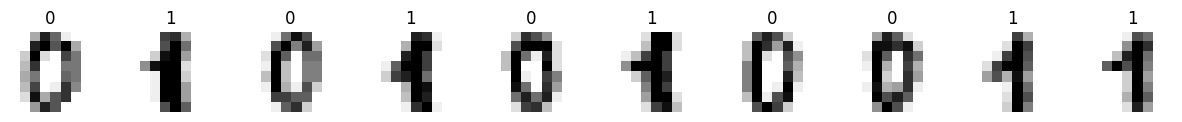

In [6]:
# load two class data (0 and 1) from sklearn dataset
digits = datasets.load_digits(n_class=2)   

# plot some data
fig, axes = plt.subplots(1, 10, figsize=(15, 15), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.5, wspace=0.5))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(digits.target[i])

There are ~180 samples per class. Each datapoint is an 8x8 image of a digit, collapsed into an array, where each element is an integer between 0 (white) and 16 (black). To use the dataset for quantum classification, we need to scale the range to between -1 and 1, and reduce the dimensionality to the number of qubits we want to use (here n_dim=8).

In [7]:
# split dataset
sample_train, sample_test, labels_train, labels_test = train_test_split(
     digits.data, digits.target, test_size=0.7, random_state=22)

# reduce dimensions
n_dim = 8
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# standardize
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Normalize
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# select 25 set of data for learning and 10 for test 
train_size = 25
sample_train = sample_train[:train_size]
labels_train = labels_train[:train_size]

test_size = 10
sample_test = sample_test[:test_size]
labels_test = labels_test[:test_size]

In [8]:
# show the first data sample
print(sample_train[0], labels_train[0])
print(sample_test[0], labels_test[0])

[-0.91749803 -0.16718998 -0.50461104 -0.39108743 -0.39591321 -0.20579425
  0.03043893  0.2636446 ] 0
[ 0.40600558 -0.74742494  0.73281596 -0.23290429 -0.35820492 -0.36234378
  0.14955469  0.00752033] 1


In [9]:
labels_train

array([0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1])

## Data encoding

The general task of machine learning, including the current task, classification, is to find and study patterns in data. Many machine learning algorithms map their input dataset to a higher dimensional feature space, through the use of a kernel function.

Looking at the data set in the left figure below, it's clear there is structure to it, but the two circles are not linearly separable in two dimensions. Let's transform the data into three dimensions, where $z = x^2+y^2$:


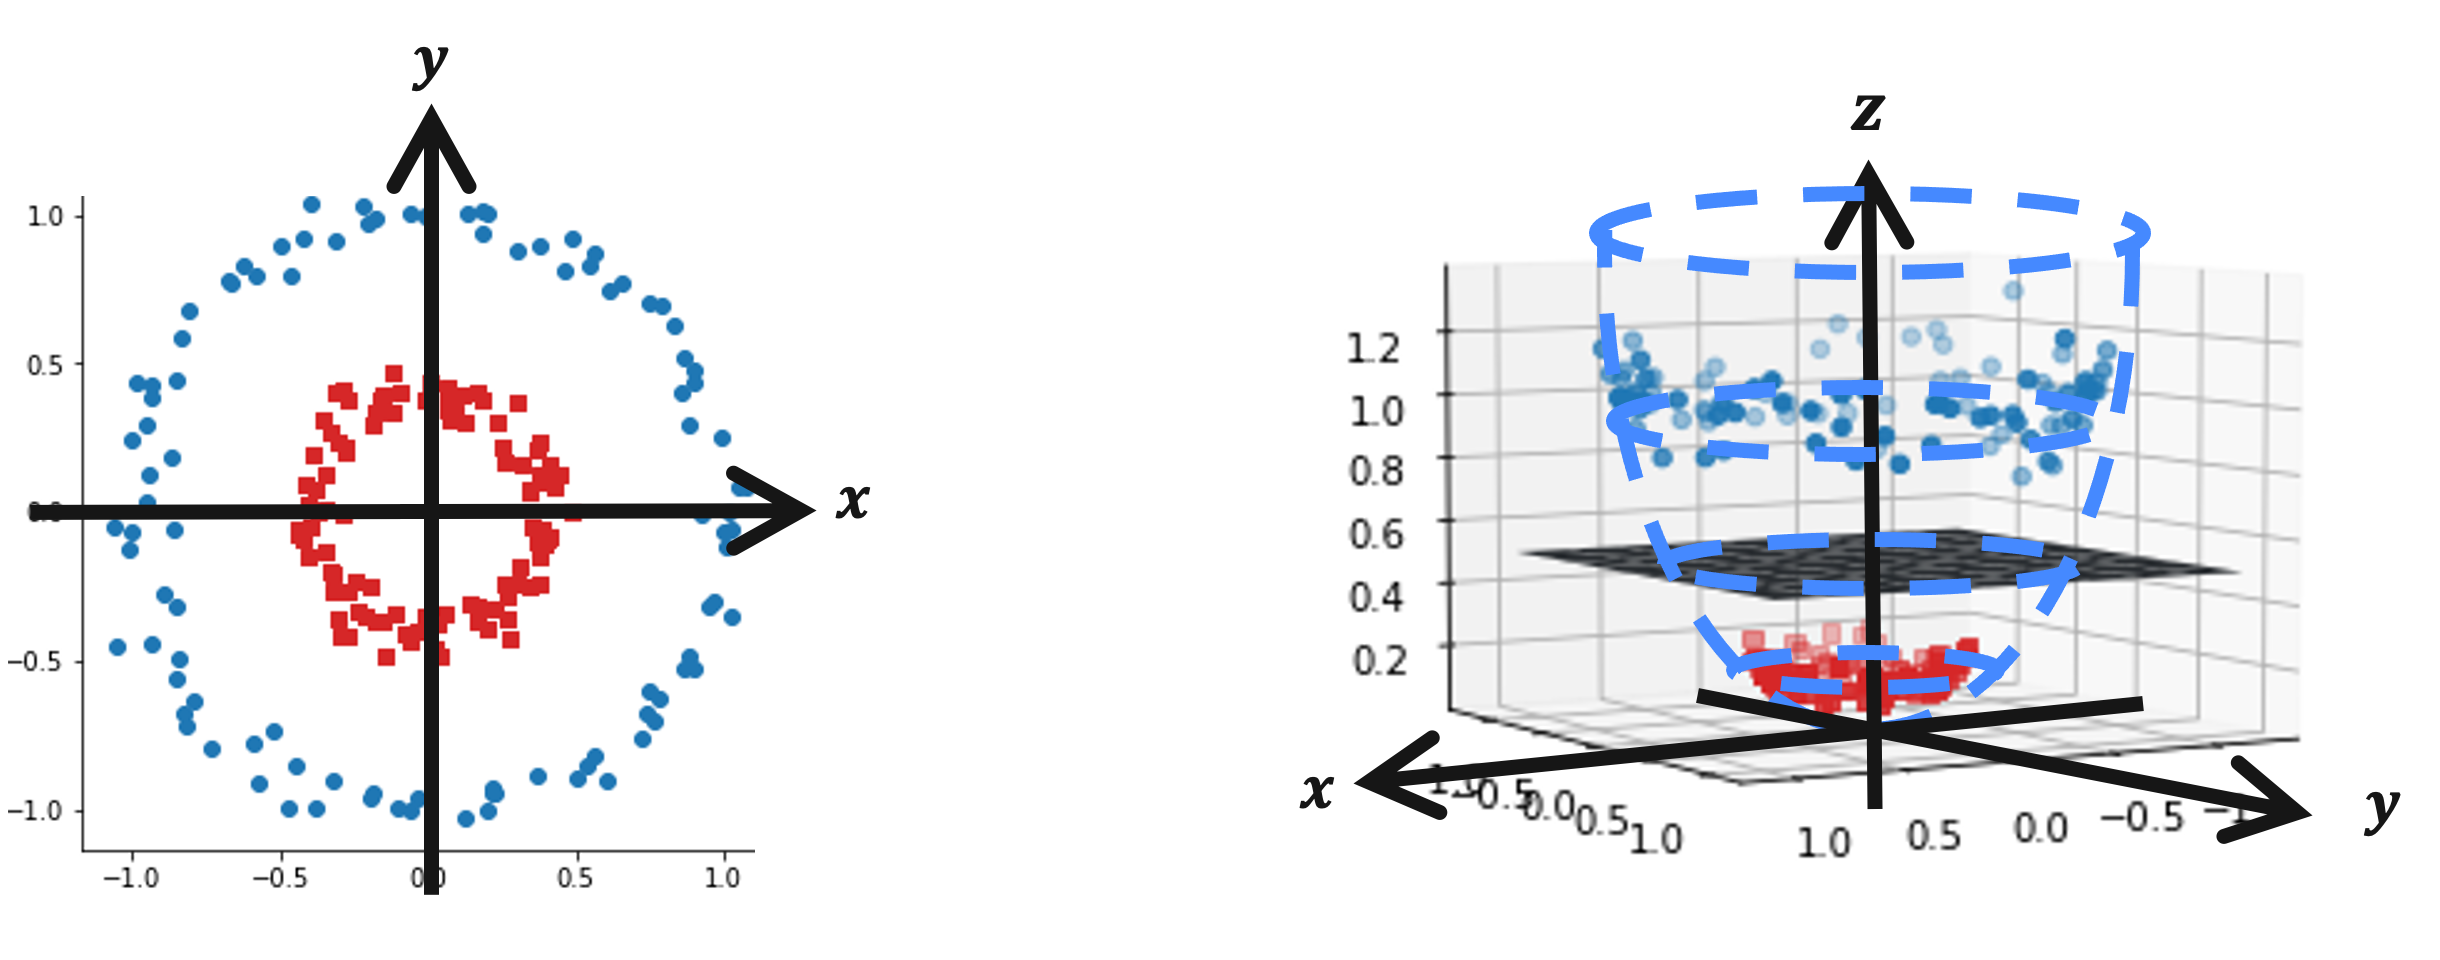

As we can see above right, in three dimensions, the data is separable by a hyperplane at $z=0.5$.

In quantum machine learning, a quantum feature map transforms $\vec{x} \rightarrow | \phi(\vec{x})\rangle$ using a unitary transformation $\vec{U_\phi}(\vec{x})$, which is typically a parameterized quantum circuit. Parametrized quantum circuits in quantum machine learning tend to be used for encoding data and as a quantum model. Their parameters are determined by the data being encoded and optimization process. They can generate a key subset of the states within the output Hilbert space and it allows them to be used as machine learning model. To learn more about parametrized quantum circuit, refer to **["Parameterized quantum circuit properties"](https://learn.qiskit.org/course/machine-learning/parameterized-quantum-circuits)** chapter in qiskit textbook.

In order to possibly obtain advantage over classical machine learning, it is important to construct quantum feature maps based on parameterized quantum circuit that are conjectured to be hard to simulate classically, but can be implemented on noisy quantum devices. The quantum feature map with depth $d$ can be implemented as bellow

$$ \mathcal{U}_{\Phi(\vec{x})} = \prod_d U_{\Phi(\vec{x})}H^{\otimes n} $$

$$ U_{\Phi(\vec{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\vec{x})\prod_{k\in S} P_i\right) $$

which contains layers of Hadamard gates interleaved with entangling blocks $U_{\Phi(\vec{x})}$, sections of a circuit that contain entangling gates (such as CNOTs), encoding the classical data as shown in circuit diagram below for $d=2$.

<center><img src="https://learn.qiskit.org/content/quantum-machine-learning/images/kernel/featuremap.svg"/></center>

Within the entangling blocks, $U_{\Phi(\vec{x})}$: $P_i \in \{ I, X, Y, Z \}$ denotes the Pauli matrices, the index $S$ describes connectivity between different qubits or data points.
Pauli matrices are shown as below.

$$ I = \sigma_0 = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} $$


$$ X = \sigma_1 = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} $$

$$ Y = \sigma_2 = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix} $$

$$ Z = \sigma_3 = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} $$


In this lab, we will use **[RealAmplitude](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html)** to build a parameterized quantum circuit. 


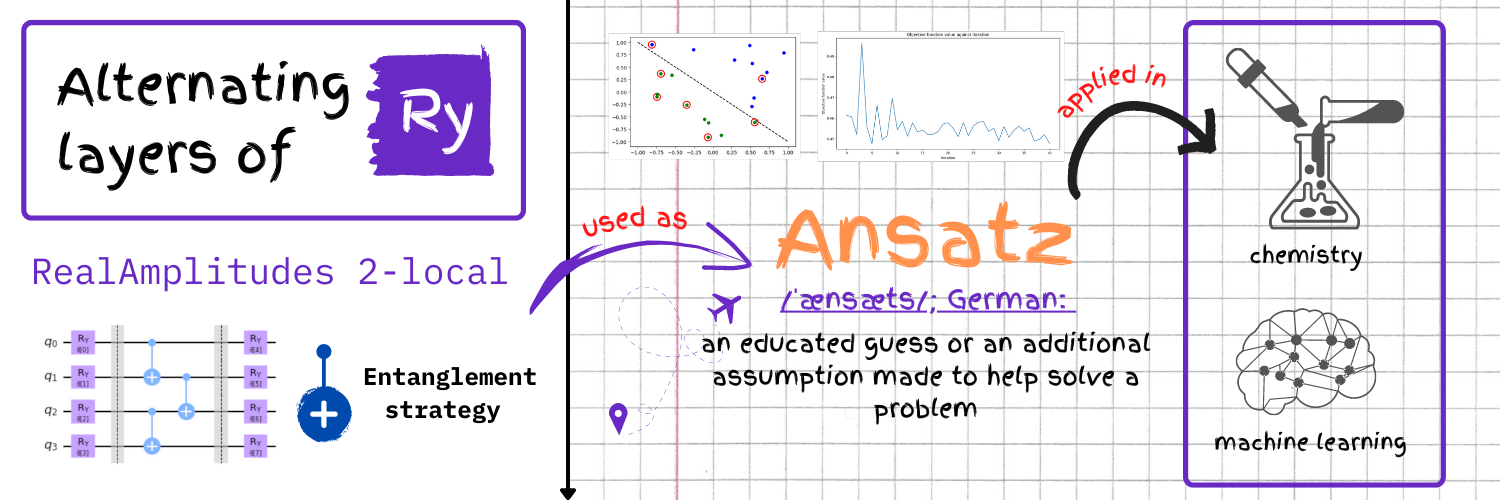

<a id="exercise1"></a>

<div class="alert alert-block alert-success">
<b>Exercise 1: </b> 
    
Use `RealAmplitude` to build a **parameterized quantum circuit** shown in the figure below. 
</div>

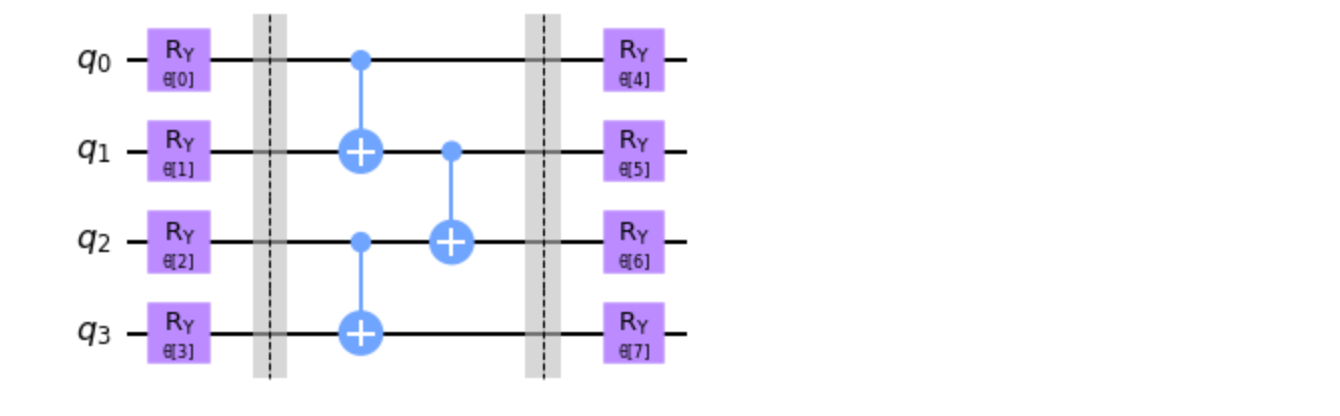

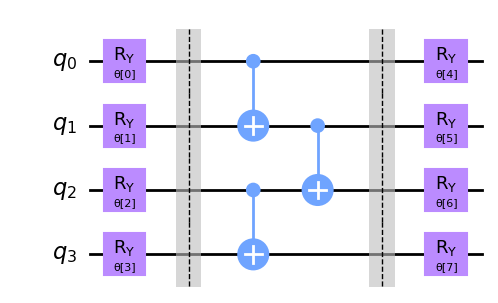

In [36]:
from qiskit.circuit.library import RealAmplitudes

def lab2_ex1():
    qc = QuantumCircuit(4)
    ansatz = RealAmplitudes(4, entanglement="pairwise", reps=1, insert_barriers=True)
    qc.compose(ansatz, inplace=True)
    return qc

qc = lab2_ex1()
qc.decompose().draw('mpl')

In [37]:
# Submit your answer using following code
from qc_grader.challenges.fall_2022 import grade_lab2_ex1

grade_lab2_ex1(lab2_ex1())

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Distribution errors using a quantum computer that mimics a real machine

Let's input the sample_train[0] data into the parameters and explore the probability distribution output by this circuit. Run it on a quantum simulator (qasm_simulator) and a noisy simulator (FakeManilaV2) that mimics a real machine to see how much we have to improve the accuracy.

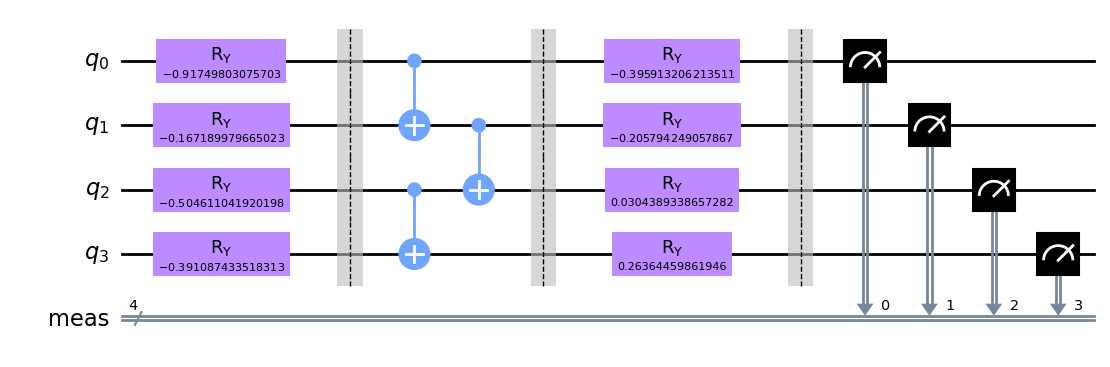

In [12]:
encode = qc.bind_parameters(sample_train[0])
encode.measure_all()
encode.decompose().draw("mpl")

In [13]:
# Use Aer's qasm_simulator
from qiskit import Aer
backend_sim = Aer.get_backend('qasm_simulator')

from qiskit import transpile
job_sim = backend_sim.run(transpile(encode, backend_sim), shots=1024)
result_sim = job_sim.result()
counts_ideal = result_sim.get_counts(encode)

In [14]:
from qiskit.providers.fake_provider import FakeManilaV2
# Get a fake backend from the fake provider
noisy_backend = FakeManilaV2()

# Run the transpiled circuit using the simulated fake backend
job_noisy = noisy_backend.run(transpile(encode, noisy_backend), shots=1024)
result_noisy = job_noisy.result()
counts_noisy = result_noisy.get_counts(encode)

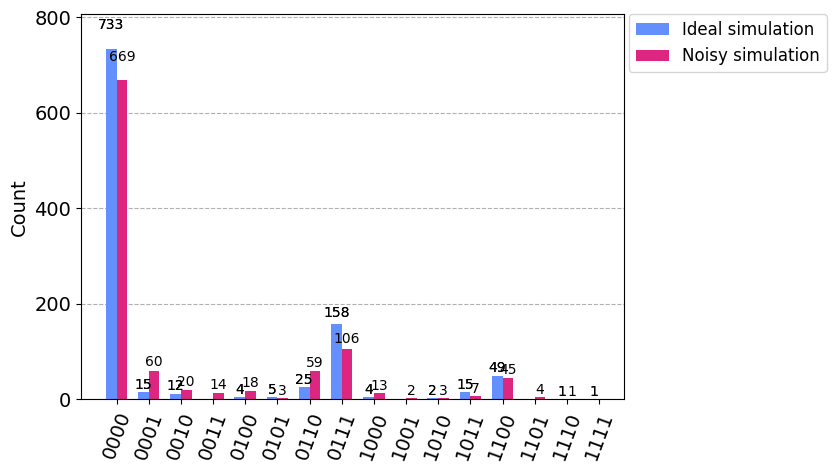

In [15]:
from qiskit.visualization import plot_histogram
legend = ['Ideal simulation', 'Noisy simulation']
plot_histogram([counts_ideal, counts_noisy], legend=legend)

# Part II: Implementing Error Mitigation in a Sampler

Fault tolerant quantum computing is still a while away. We are now in the near-time quantum computing era which means we have to devise ways to deal with quantum noise.

When using a real quantum computer, it is necessary to think about how to reduce the noise. Qiskit Runtime Primitives can apply error mitigation when running on a real quantum computer. Here we consider the use of matrix-free measurement mitigation (M3). Please refer to chapter 4.1 of Lab1 to recall M3 and answer the following exercise.


<a id="exercise2"></a>

<div class="alert alert-block alert-success">
<b>Exercise 2:</b> 
    
Please answer yes or no if the following statements describing **Matrix-free Measurement Mitigation (M3)** are correct.
- Q1: M3 is a quantum gate error mitigation technique and is used for fault tolerant quantum computer.

- Q2: M3 works in subspace that is created by reducing the exponential overhead down to a scaling that depends on the number of random bit strings.

- Q3: M3 amplifies the scale factor of noise to estimate the measured value in the absence of noise.

- Q4: M3 technique use reduced memory for mitigation compared to direct solution.    
</div>

In [16]:
# please answer 'yes' or 'no'
# Q1
answer_lab2_ex2_1 = 'no'
# Q2
answer_lab2_ex2_2 = 'no'
# Q3
answer_lab2_ex2_3 = 'no'
# Q4
answer_lab2_ex2_4 = 'yes'

# Submit your answer using following code
from qc_grader.challenges.fall_2022 import grade_lab2_ex2
grade_lab2_ex2(answer_lab2_ex2_1, answer_lab2_ex2_2, answer_lab2_ex2_3, answer_lab2_ex2_4)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Here we show how to use the sampler to generate (quasi-) probability distributions by running and measuring the parameterized quantum circuit made before. Without error mitigation, the `Sampler` returns a probability distribution corresponding to the measured samples. 

In [17]:
# Runtime sampler using Sessions
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, Sampler

In [18]:
# Save the Runtime account credenials if you have not done so already
# If you need to overwrite the account info, please add `overwrite=True`
QiskitRuntimeService.save_account(channel='ibm_quantum', token=my_token, overwrite=True)

In [19]:
# authenticate at Qiskit runtime service
service = QiskitRuntimeService()
# choose a cloud simulator
backend = service.backends(simulator=True)[0]

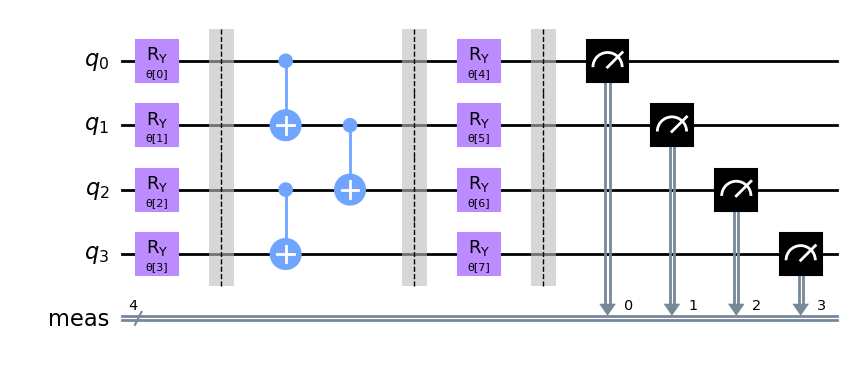

In [20]:
qc.measure_all()
qc.decompose().draw('mpl')

In [21]:
# Do not change the seed of simulatior in Options
options = Options(simulator={"seed_simulator": 1234},resilience_level=0)

In [22]:
shots = 10000
with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(circuits=[qc], parameter_values=[sample_train[0]], shots=shots)
    samples_sim = job.result()

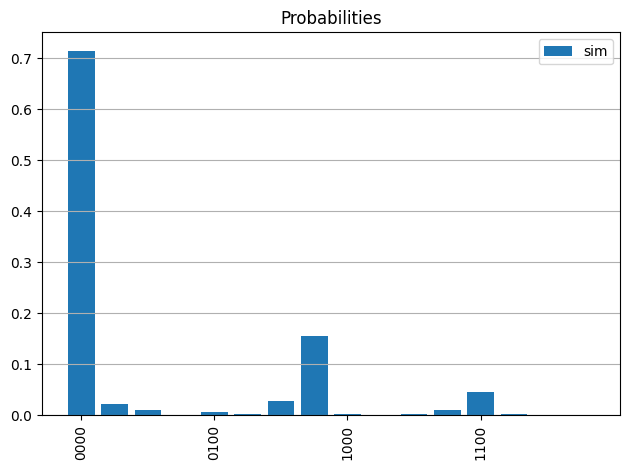

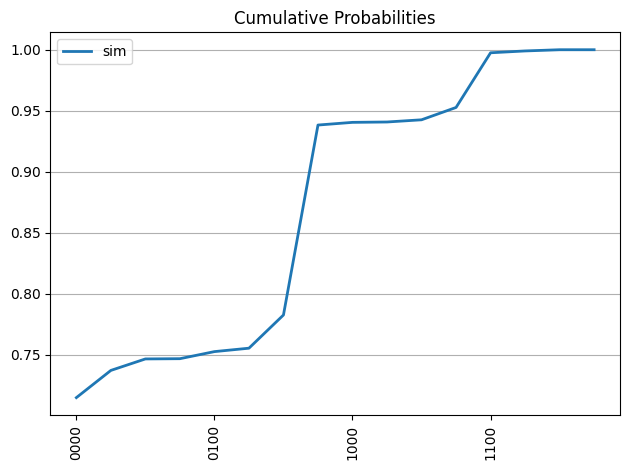

In [23]:
# illustrate resulting (cumulative) probabilities
probs_sim = process_samples(qc, samples_sim)
plot_probabilities(qc, probs_sim, 'sim')
plot_cumulative_probabilities(qc, [probs_sim], ['sim'])

Next, we will also get the probability distribution using a noisy simulator instead of real backend. For using the noisy simulator, we need to create a noise model with a fake backend from the fake provider.

The fake provider module contains fake providers and fake backends classes. The fake backends are built to mimic the behaviors of IBM Quantum systems using system snapshots. The system snapshots contain important information about the quantum system such as coupling map, basis gates, qubit properties (T1, T2, error rate, etc.) which are useful for performing noisy simulation of the system.

In this case, we will import `FakeManila` to make the noise model. With the model, we can configure several data which are noise model, basis gates, coupling map, and seed in `simulator` option inside of `Options`.

In [39]:
from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel

fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)

options_noise = Options(
    simulator={
        "noise_model": noise_model,
        "seed_simulator": 1234
    },
    resilience_level=0
)

In [25]:
with Session(service=service, backend=backend):
    sampler = Sampler(options=options_noise)
    job = sampler.run(circuits=[qc], parameter_values=[sample_train[0]], shots=shots)
    samples_noise = job.result()

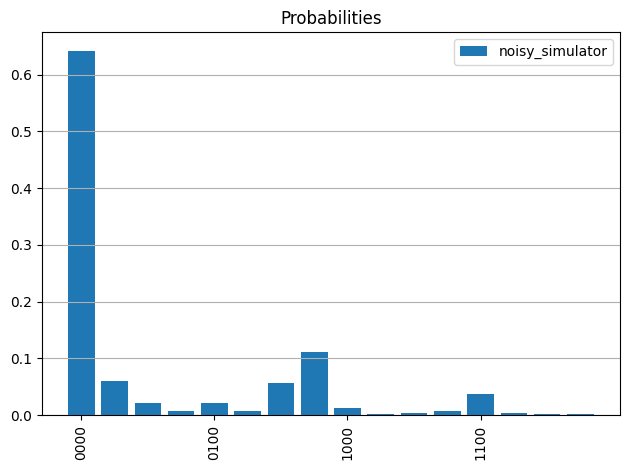

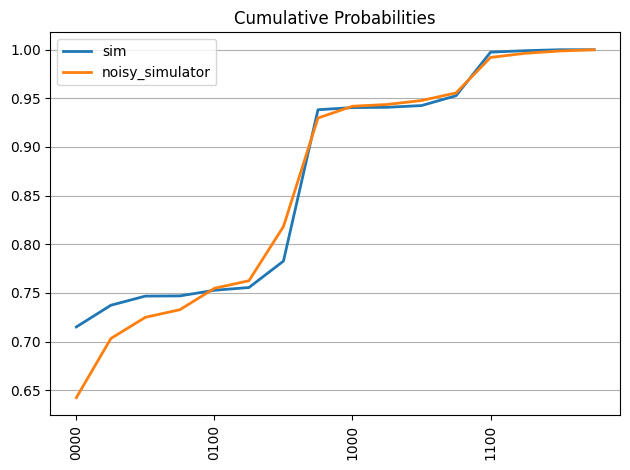

In [26]:
# illustrate resulting (cumulative) probabilities
probs_noise = process_samples(qc, samples_noise)
plot_probabilities(qc,probs_noise, 'noisy_simulator')
plot_cumulative_probabilities(qc,[probs_sim, probs_noise], ['sim', 'noisy_simulator'])

To use M3 mitigation feature in Qiskit Runtime, add `resilience_level=1` to the `options` argument. 

In [27]:
options_with_em = Options(
    simulator={
        "noise_model": noise_model,
        "seed_simulator": 1234
    },
    resilience_level=1,
)

In [28]:
with Session(service=service, backend=backend):
    sampler = Sampler(options=options_with_em)
    job = sampler.run(circuits=[qc], parameter_values=[sample_train[0]], shots=shots)
    samples_with_em = job.result()

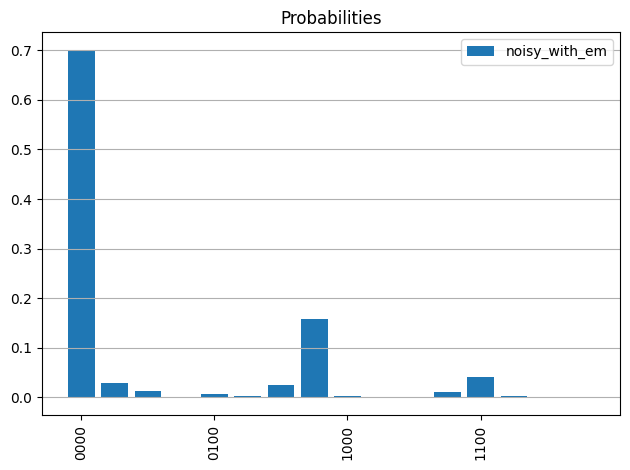

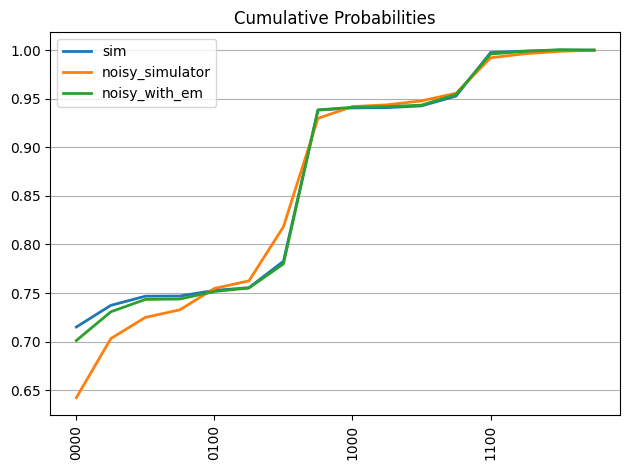

In [29]:
# illustrate resulting (cumulative) probabilities
probs_with_em = process_samples(qc, samples_with_em)
plot_probabilities(qc, probs_with_em, 'noisy_with_em')
plot_cumulative_probabilities(qc, [probs_sim, probs_noise, probs_with_em], ['sim', 'noisy_simulator', 'noisy_with_em'])

This last plot shows how error mitigation can reduce the errors and lead to a probability distribution that is significantly closer to the ideally simulated one.

# Part III: Estimating State Fidelities with a Sampler

A frequent application of the sampler is the estimation of the fidelity of two quantum states.

The fidelity is a measure of the closeness of two quantum states. Let's say there are two quantum states $\rho$ and $\sigma$ and think about how to distinguish them. With their fidelity, you can easily know how much they are similar to each other, in other words, how much they are close to each other. The value of the fidelity is between $0$ and $1$. If you find the fidelity is $1$, it means two states are exactly same. Or if the value is $0$, you can perceive they are completely different. Note that the fidelity is not a metric on the space of density matrices, but it can be used to define the Bures metric on this space. 

Given two states $|\psi\rangle = U|0\rangle$ and $|\varphi\rangle = V|0\rangle$, generated by the unitaries $U$ and $V$, the fidelity is defined as

$$\left|\langle \psi \mid \varphi \rangle\right|^2 = \left|\langle 0 \mid U^{\dagger} V \mid 0\rangle \right|^2.$$

This can be estimated by first applying $V$, then the inverse of $U$, and then measuring the probability of $|0\rangle$.

For our illustration we set $U = V$ to be parametrized circuits and vary the parameters to achieve different states.

Let's build the fidelity circuit of the circuit of Exercise 1.

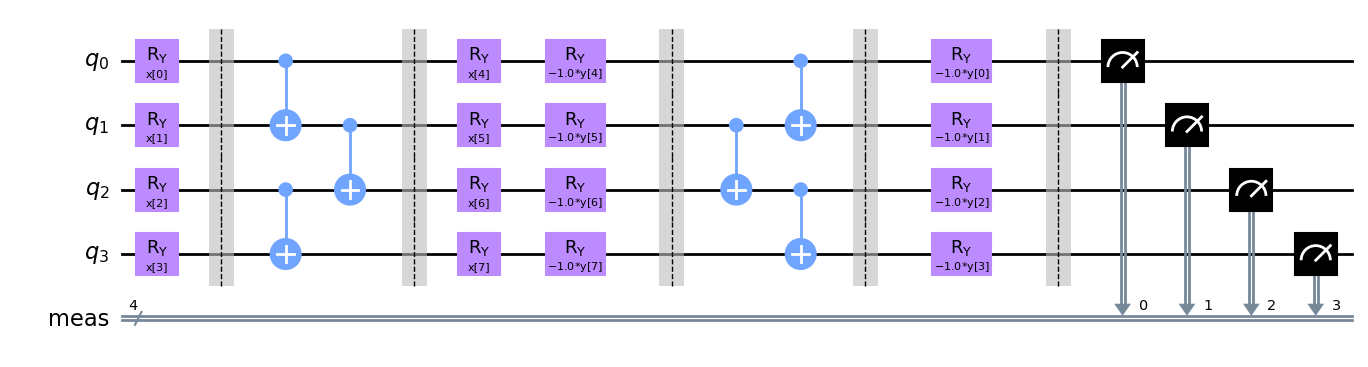

In [30]:
# parametrized circuit defining U first state
circuit_1 = RealAmplitudes(4, reps=1, entanglement='pairwise', 
                           insert_barriers=True, parameter_prefix='x')
    
# parametrized circuit V defining second state
circuit_2 = RealAmplitudes(4, reps=1, entanglement='pairwise', 
                           insert_barriers=True, parameter_prefix='y')

# combining circuits to evaluate U^dagger V
fidelity_circuit = circuit_1.copy()
fidelity_circuit.append(circuit_2.inverse().decompose(), range(fidelity_circuit.num_qubits))
fidelity_circuit.measure_all()

# drawing resulting circuit to estimate fidelity
fidelity_circuit.decompose().draw('mpl')

We illustrate the fidelity estimation by parameters $\theta_1, \theta_2$ for the two states. Then we calculate the fidelity between the state corresponding to $\theta_1$ and the states corresponding to $\theta_1 + c * (\theta_2 - \theta_1)$ for $c \in [0, 1]$.

Since we use the same parametrized circuit for both states, $c=0$ implies that both states correspond to $\theta_1$ and the fidelity is supposed to be equal to $1$. With increasing $c$, the fidelity declines (up to a certain point, depending on $\theta_2$).

We will input `sample_train[0]` and `sample_train[2]` for $\theta_1, \theta_2$.

In [51]:
# draw parameters for states 1 & 2
theta_1 = sample_train[0] # label"0"
theta_2 = sample_train[2] # label"1"

# linear combinations of theta_1 and theta_2
thetas = [theta_1 + c * (theta_2 - theta_1) for c in np.linspace(0, 1, 10)]

# list the parameters
theta_list = []
for theta_ in thetas:
    theta_list.append(list(theta_1) + list(theta_))

<a id="exercise3"></a>

<div class="alert alert-block alert-success">
<b>Exercise 3:</b> 

Build the **sampler** codes to find the **state fidelity** under the following conditions.
When using a real quantum computer, it is necessary to think about how to deal with noise. The number of shots should be fixed to `shots = 10000`. 
    
- Ideal simulator
- Noisy devices simulator `FakeManila` without error mitigation
- Noisy devices simulator `FakeManila` with error mitigation
    
As before, we use `resilience_level=1` to calculate sample fidelity using M3 mitigation.

</div>

In [32]:
# create sampler using simulator and sample fidelities
with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(circuits=[fidelity_circuit]*len(theta_list), parameter_values=theta_list, shots=shots)
    fidelity_samples_sim = job.result()

    sampler = Sampler(options=options_noise)
    job =  sampler.run(circuits=[fidelity_circuit]*len(theta_list), parameter_values=theta_list, shots=shots)
    fidelity_samples_noise = job.result()
    
    sampler = Sampler(options=options_with_em)
    job =  sampler.run(circuits=[fidelity_circuit]*len(theta_list), parameter_values=theta_list, shots=shots)
    fidelity_samples_with_em = job.result()
    
fidelities_sim = []
fidelities_noise = []
fidelities_with_em = []

for i in range(10):
    fidelities_sim += [fidelity_samples_sim.quasi_dists[i][0]]
    fidelities_noise += [fidelity_samples_noise.quasi_dists[i][0]]
    fidelities_with_em += [fidelity_samples_with_em.quasi_dists[i][0]]

In [33]:
# Submit your answer using following code
from qc_grader.challenges.fall_2022 import grade_lab2_ex3

grade_lab2_ex3(fidelities_sim, fidelities_noise, fidelities_with_em)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


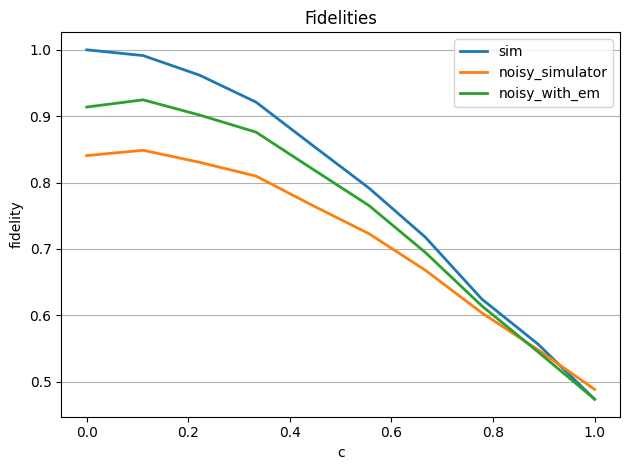

In [34]:
# plot resulting fidelities for different linear combinations of theta_1 and theta_2
plot_fidelities([fidelities_sim, fidelities_noise, fidelities_with_em], ['sim', 'noisy_simulator', 'noisy_with_em'])

Again, from this last plot, we can see that the error reduction results in a fidelity that is quite close to the simulation.

# Part IV: Quantum Kernels and Quantum Support Vector Machines

Based on the fidelity circuit, we can build a function that evaluates the quantum kernel.

A quantum support vector machine (QSVM) is a classical support vector machine with a quantum kernel.  A common approach to define quantum kernels is making the fidelity of two different input of feature map, which corresponds to the Hilbert-Schmidt inner product in feature space.

### Quantum Kernel Machine Learning

Machine learning algorithms can map the input dataset to higher dimensional feature map using kernel function, $k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle $ where $k$ is kernel function, $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs, $f$ is map from $n$-dimension to $m$-dimension space. When we consider that data is finite, the quantum kernel can be expressed as matrix, 

$$K_{ij}=|\langle\phi^{\dagger}(\vec{x}_j)|\phi(\vec{x}_i)\rangle|^2$$ 

Considering that the feature map is a parameterized quantum circuit we can calculate that kernel matrix with $n$ qubits is 

$$|\langle\phi^{\dagger}(\vec{x}_j)|\phi(\vec{x}_i)\rangle|^2 = |\langle 0^{\otimes n}|U^{\dagger}_{\phi(\vec{x}_j)} U_{\phi(\vec{x}_i)}|0^{\otimes n} \rangle |^2$$ 

Quantum kernel support vector classification algorithm follow these steps to construct a hyperplane in feature space for classification and regression **[[5]](https://www.nature.com/articles/s41586-019-0980-2) [[6]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.040504)**.

1. Build the train quantum kernel matrices. Apply the feature map and measure transition probability, $K_{ij}=|\langle 0|U^{\dagger}_{\phi(\vec{x}_j)} U_{\phi(\vec{x}_i)}|0 \rangle |^2$ for each pair of data points in the training dataset $\vec{x}_i,\vec{x}_j$.
2. Build the test quantum kernel matrices. Apply the feature map and measure the transition probability, $K_{ij}=|\langle 0|U^{\dagger}_{\phi(\vec{y}_i)} U_{\phi(\vec{x}_i)}|0 \rangle |^2$ for each training data point $\vec{x}_i$ and testing point $\vec{y}_i$.
3. Classical support vector machine classification algorithm uses train and test quantum kernel matrices.

The hyperplane ideally has the largest distance to the nearest training data points for any class.

<center><img src="https://learn.qiskit.org/content/quantum-machine-learning/images/kernel/qsvc.svg"/></center>

Let's build the quantum kernel circuit using the fidelity circuit. However, depending on the dataset, the QSVM is surprisingly robust against noise, here we will apply error mitigations to ensure reliable calculations.

A few things to note about the kernel matrix:

- Each row / column represents the transition amplitude of a single data point, with all other data points in the dataset
- The transition amplitude of a data point with itself is 1, so the matrix has a unit diagonal
- The matrix is symmetric, the transition amplitude of $x \rightarrow y$ is the same as $y \rightarrow x$.

### The number of kernel elements we should calculate
When the number of data is $n$, the kernel matrix is $n \times n$ and has $n^2$ elements. However, since the kernel matrix is a symmetric matrix, the number of elements to be computed can be reduced. When the number of data is $n$, the number of elements of the kernel matrix that must be computed is;
$$ (n-1) + (n-2) + ... + 2 + 1 $$
We need to create this number of quantum kernel parameterization circuits and compute them. 

For example, when the number of data is $n=25$, the kernel matrix has $25\times25=625$ elements, but the number of elements required for calculation is $300$.


In [41]:
n = 25   
circuit_num = np.arange(0,n).sum()
print(circuit_num)

300


### The function that encodes data into the quantum kernel circuit
Next, we will create a function `data_append` that encodes data into the quantum kernel circuit. `n` is the number of data, and `x1`, `x2` are the lists of data to input.

In [53]:
def data_append(n, x1, x2):
    para_data = []
    #
    for i in range(n):
        for j in range(n):
            if i<j:
                para_data.append(list(x1[i])+list(x2[j]))
    #   
    return para_data

<a id="exercise4"></a>

<div class="alert alert-block alert-success">
<b>Exercise 4:</b> 

Build the **Quantum Kernel** code using `circuit_num` and `data_append` with **Sampler**. As training data, use `sample_train` which you created in the earlier chapter, "Handwritten bit strings". You need to use the noisy simulator `FakeManila` with the error mitigation, `resilience_level=1`. 

**Notes**: Do not change the seed of simulator in Options:`"seed_simulator": 1234`. The number of shots should be fixed to `shots = 10000`. 

</div>

In [107]:
len(data_append(25, sample_train, sample_train))


300

In [113]:
with Session(service=service, backend=backend):
    sampler = Sampler(options=options_with_em) # FakeManila with error mitigation
    job =  sampler.run(circuits=[fidelity_circuit]*circuit_num, parameter_values=data_append(n, sample_train, sample_train), shots=shots)
    quantum_kernel_em = job.result()

len(quantum_kernel_em.quasi_dists)

300

In [110]:
kernel_em = []
for i in range(circuit_num):
    kernel_em += [quantum_kernel_em.quasi_dists[i][0]]

You can show the kernel matrix $K_{ij}$ with the code below.

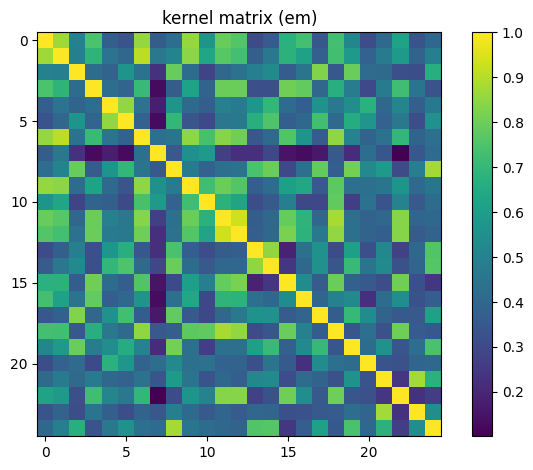

In [111]:
K = np.zeros((n, n))
count = 0
for i in range(n):
    for j in range(n):
        if j<i:
            K[i,j] = K[j,i]
        else:
            if j==i:
                K[i,j] = 1
            else:
                K[i,j] = kernel_em[count]
                count+=1
plot_matrix(K, 'kernel matrix (em)')

In the above plot, you can check the feature of the kernel matrix $K_{ij}=|\langle\phi^{\dagger}(\vec{x}_j)|\phi(\vec{x}_i)\rangle|^2$ described earlier:

- Each row / column represents the transition amplitude of a single data point, with all other data points in the dataset
- The transition amplitude of a data point with itself is 1, so the matrix has a unit diagonal
- The matrix is symmetric, the transition amplitude of $x \rightarrow y$ is the same as $y \rightarrow x$.

In [112]:
# Submit your answer using following code
from qc_grader.challenges.fall_2022 import grade_lab2_ex4

grade_lab2_ex4(kernel_em)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Using labels for train data, let's check the accuracy of training.

In [114]:
svc = SVC(kernel='precomputed')
# train SVM
svc.fit(K, labels_train)

# score SVM on training data
y_predict = svc.predict(K)
print('accuracy (sim):', sum(y_predict == labels_train)/len(labels_train))

accuracy (sim): 1.0


In [115]:
print(labels_train, y_predict)

[0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 0 1 1] [0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 0 1 1]


Congratulations! You have successfully created an accurate quantum classifier.

<a id="exercise5"></a>

<div class="alert alert-block alert-success">
<b>Exercise 5:</b> 

**Decode the unknown bitstring** `unknown_data` to check if your quantum classifier is working properly.<br>
You need to modify `circuit_num` and the function `data_append` which encodes data into the quantum kernel circuit to accommodate kernels that are not square matrices. You need to use the noisy simulator `FakeManila` with the error mitigation, `resilience_level=1`. Submit below two results.
- Decoding result of unknown bitstring: `ex5_predict`
- Kernel matrix calculated with `unknown_data` and `sample_train`: `kernel_ex5`

**Notes**: Do not change the seed of simulator in Options:`"seed_simulator": 1234`. The number of shots should be fixed to `shots = 10000`. 

</div>    

In [116]:
unknown_data = ([[ 0.88925334, -0.45107705, -0.17165649,  0.21764645,  0.06976178,
        -0.56642651, -0.2177827 ,  0.0399222 ],
       [-0.58864187, -0.21179537, -0.52811919, -0.5568292 , -0.09719389,
        -0.87511725, -0.29104206, -0.3959822 ],
       [-0.4408889 , -0.113614  , -0.55612463, -0.3135209 , -0.37814493,
        -0.54298913, -0.43088957, -0.30052965],
       [ 0.73914419, -0.67147632, -0.43496568,  0.15402565, -0.2403563 ,
        -0.22006604, -0.07169684, -0.06741802],
       [-0.57393773, -0.27554408, -0.19539549,  0.38801239,  0.74179855,
         0.45881712, -0.08612418, -0.12852764],
       [ 0.84167362, -0.62435747, -0.10059876,  0.5794717 , -0.21003759,
        -0.34971761, -0.10780177, -0.47967332],
       [-0.68499849, -0.20315101, -0.3042834 ,  0.15454653,  0.16849424,
         0.43281474, -0.25603947, -0.38992326],
       [ 0.05483369,  0.94238598, -0.07558843, -0.07849555,  0.14751995,
        -0.48487454,  0.10211269, -0.17232739],
       [ 0.47194409, -0.52603499,  0.76659229, -0.90257671,  0.18145297,
         0.14082232, -0.27658999, -0.0995099 ],
       [ 0.89040898, -0.573903  , -0.11297795,  0.67050626,  0.00995783,
        -0.5648723 , -0.23517219,  0.07979215]])

### The number of kernel elements we should calculate
Build your code for `circuit_num_ex5` to get the number of kernel elements we should calculate to decode the unknown bitstring.

In [121]:
n1 = len(unknown_data) # the number of unknown bit-string
n2 = 25 # the number of trained data
circuit_num_ex5 = n1 * n2
print(circuit_num_ex5)

250


### The function that encodes data into the quantum kernel circuit
Create a function `data_append_ex5` that encodes data into the quantum kernel circuit for decoding the unknown bitstring. The arguments are;
- n1: int, the number of unknown bitstrings
- n2: int, the number of trained data
- x1: list, unknown data
- x2: list, trained sample data

In [125]:
def data_append_ex5(n1, n2, x1, x2):
    # Write your code here
    para_data_ex5 = []
    for i in range(n1):
        for j in range(n2):
            para_data_ex5.append(list(x1[i])+list(x2[j]))
    return para_data_ex5

Next, build the sampler code to calculate the Quantum kernel element for the unknown bitstring.

In [127]:
with Session(service=service, backend=backend):   
    sampler = Sampler(options=options_with_em)
    job =  sampler.run(circuits=[fidelity_circuit]*circuit_num_ex5, parameter_values=data_append_ex5(n1, n2, unknown_data, sample_train), shots=shots)
    quantum_kernel_ex5 = job.result()  

You can show the kernel matrix with the code below.

In [128]:
kernel_ex5 = []
for i in range(circuit_num_ex5):
    kernel_ex5 += [quantum_kernel_ex5.quasi_dists[i][0]]

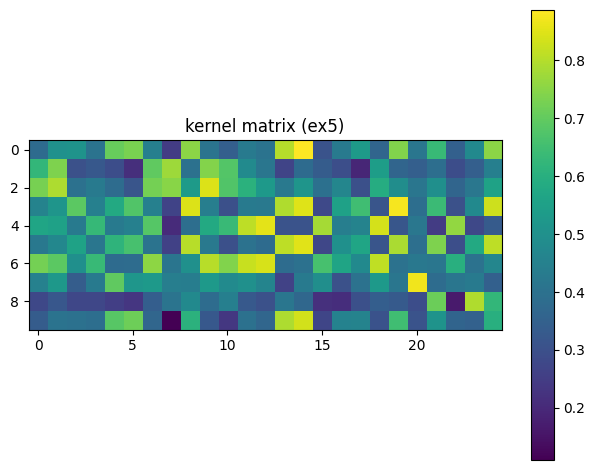

In [129]:
K_ex5 = np.zeros((n1, n2))
count = 0
for i in range(n1):
    for j in range(n2):
        K_ex5[i,j] = kernel_ex5[count]
        count+=1
plot_matrix(K_ex5, 'kernel matrix (ex5)')

Predict the unknown bitstring with the code below.

In [130]:
ex5_predict = svc.predict(K_ex5)
print(ex5_predict)

[1 0 0 1 0 1 0 1 1 1]


In [131]:
# Submit your answer using following code
from qc_grader.challenges.fall_2022 import grade_lab2_ex5

grade_lab2_ex5(ex5_predict, kernel_ex5)

Submitting your answer. Please wait...

Congratulations 🎉! Your answer is correct.

You successfully fixed your quantum computers and scanners. Now you can use them to find your way
home.

You use the newly-fixed scanners to analyze your surroundings, and discover there are even more
little worlds orbiting the black hole than you first thought.

One of the worlds is your optimal target for a slingshot maneuver.
And one of worlds is where future you is stuck, in its own little bubble of time.
        


# References
- [1] **[Introduction to Quantum Machine Learning - Qiskit Learn](https://learn.qiskit.org/course/machine-learning/introduction)**
- [2] **[Key questions for the quantum machine learners to ask themselves - Nathan Wiebe](https://iopscience.iop.org/article/10.1088/1367-2630/abac39/meta)**
- [3] **[Quantum machine learning - Jacob Biamonte, Peter Wittek, Nicola Pancotti, Patrick Rebentrost, Nathan Wiebe & Seth Lloyd](https://www.nature.com/articles/nature23474)**
- [4] **[Quantum feature maps and kernels - Qiskit Learn](https://learn.qiskit.org/course/machine-learning/quantum-feature-maps-kernels)**
- [5] **[Supervised learning with quantum-enhanced feature spaces - Vojtěch Havlíček, Antonio D. Córcoles, Kristan Temme, Aram W. Harrow, Abhinav Kandala, Jerry M. Chow & Jay M. Gambetta ](https://www.nature.com/articles/s41586-019-0980-2)**
- [6] **[Quantum Machine Learning in Feature Hilbert Spaces - Maria Schuld and Nathan Killoran](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.040504)**


# Additional information

<b>Created by:</b> Kifumi Numata, Inho Choi, Dayeong Kang

<b>Advisor:</b> Anna Phan

<b>Creative assets by:</b> Radha Pyari Sandhir

Version: 1.0

In [132]:
from qiskit.tools.jupyter import *
%qiskit_version_table
